In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
#경고무시
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install missingno

In [4]:
!pip install openpyxl

In [5]:
import missingno as msno

In [6]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [7]:
# 엑셀 불러오기
df = pd.read_excel("Dataset/Fastcampus/TeamPJT.xlsx")

In [11]:
# 수정본
df = pd.read_excel("Dataset/Fastcampus/Modify_TeamPJT.xlsx")

In [7]:
# 수정본2
df = pd.read_excel("Dataset/Fastcampus/fc_data_mini_pjt.xlsx")

In [8]:
# 저장한 데이터 불러오기
df = pd.read_csv("Dataset/Fastcampus/Fastcampus_.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56157 entries, 0 to 56156
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      56157 non-null  int64         
 1   customer_id             56157 non-null  int64         
 2   course_id               56157 non-null  int64         
 3   type                    56157 non-null  object        
 4   state                   56157 non-null  object        
 5   course_title            56157 non-null  object        
 6   category_title          56157 non-null  object        
 7   format                  56157 non-null  object        
 8   completed_at            56157 non-null  datetime64[ns]
 9   transaction_amount      56157 non-null  int64         
 10  coupon_title            23247 non-null  object        
 11  coupon_discount_amount  23247 non-null  float64       
 12  sale_price              55078 non-null  float6

In [10]:
df.head(5)

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,purchase,refund
0,970657,72297,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090.0,190900.0,190900.0,NaN,CARD,NaN,2021-03-04,True,False
1,970658,478028,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,117500.0,117500.0,NaN,CARD,PPT/보고서,2019-11-14,True,False
2,970669,478033,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,116000.0,116000.0,NaN,CARD,영상 편집,2020-12-02,True,False
3,970671,469860,203644,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,NaN,NaN,263000.0,263000.0,NaN,CARD,NaN,2020-11-27,True,False
4,970676,478035,203720,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,111000.0,111000.0,NaN,CARD,프론트엔드 개발,2021-02-02,False,False


In [10]:
# 타입 변경
df = df.astype({"customer_id":"int"})
df['completed_at']= pd.to_datetime(df['completed_at'])

In [11]:
# 날짜타입으로 변경
df['marketing_start_at']= pd.to_datetime(df['marketing_start_at'])

## 해볼 것

피쳐분석
* payment completed 이후 order cancelled가 없는것 -> 취소하지 않고 강의를 구매한 비율
* 취소하지 않고 구매한 강의의 공통점 찾기
* 광고를 시작한 이후의 시간의 경과에 따라서 구매율이 높아졌는지?(사실 판매시작일임)
* 쿠폰사용에 따른 피쳐들 분석
* 분야별 순구매율

이끌어낼 것
* 쿠폰 발행이 구매에 어떤 영향을 미치는지?
* 분야별 강의를 취소하지 않게하려면 어떤 조치를 위해야 하는지?

<AxesSubplot:>

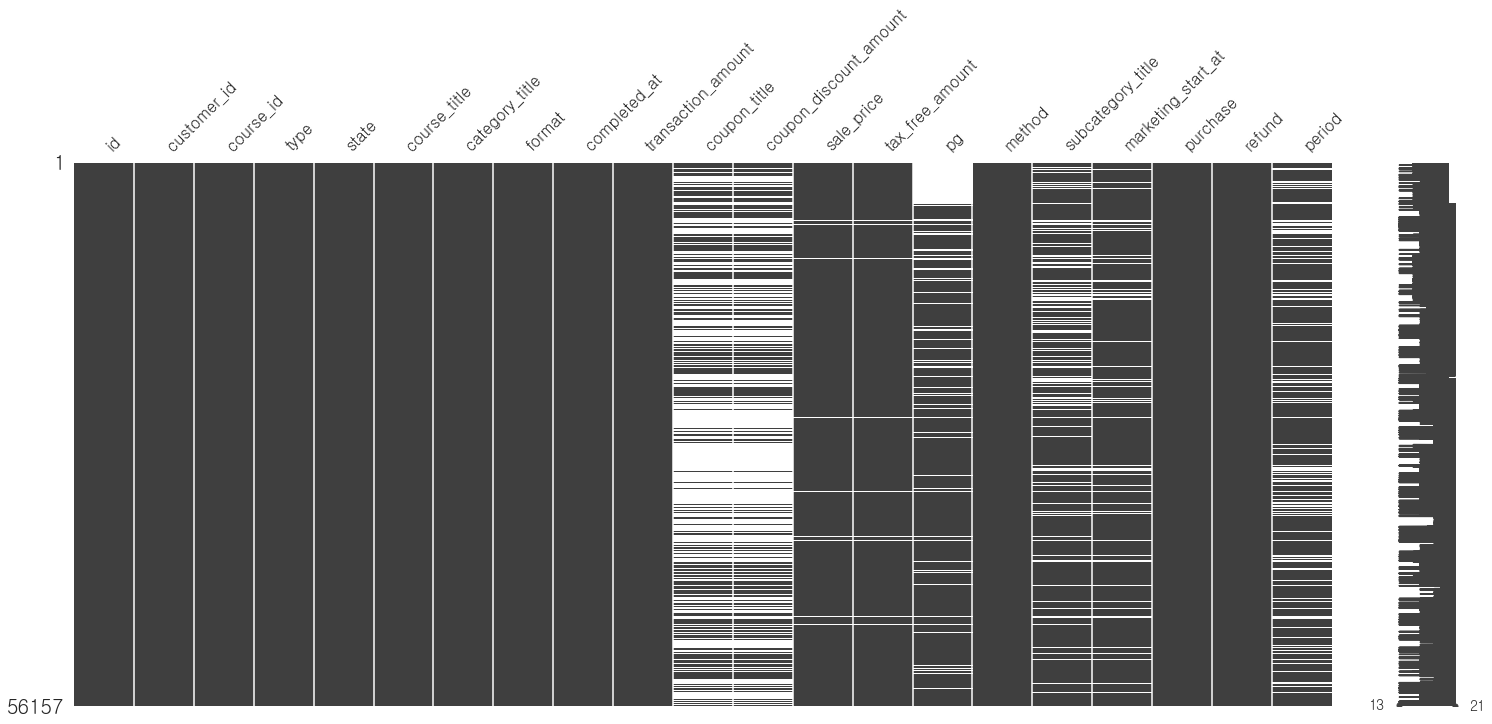

In [135]:
# 결측치 확인
msno.matrix(df=df)

In [11]:
# sale_price와 tax_free_amount가 다른것은 대부분 프로모션(현물을 주는)제품이다.

df[(df['sale_price'] != df['tax_free_amount']) & (~df['sale_price'].isnull()) & (~df['tax_free_amount'].isnull())]['course_title'].unique()

array(['스프링 아카데미아', '(TEST) 오프라인 과세 상품 결제 테스트용 상품',
       '프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 코딩 LEVEL UP 웹 개발 풀스텍 프리패스 (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 영상 퀄리티를 바꿔 줄 영상 제작 스킬 프리패스(5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 워라밸을 완성하는 직장인 필수스킬 프리패스 (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 코딩 LEVEL UP 웹 개발 풀스텍 프리패스 (5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 워라밸을 완성하는 직장인 필수스킬 프리패스 (5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 풀스택 마케터를 위한 마케팅 프리패스 (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 영상 퀄리티를 바꿔 줄 영상 제작 스킬 프리패스 (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 풀스택 마케터를 위한 마케팅 프리패스 (5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 시장의 흐름을 읽는 투자의 정석 프리패스  (5월 삼성 패키지 현물 :  삼성노트북 플러스2)',
       '프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 시장의 흐름을 읽는 투자의 정석 프리패스(5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '프로모션 : 커리어를 UP UX/UI 디자인 프리패스 (5월 삼성 패키지 현물 :  삼성 갤럭시 북 프로)',
       '(테스트용) 프로모션 : 기초부터 시작하는 데이터분석

In [38]:
# course_title가 null값인 경우 행 삭제 대부분 type이 Deleted이고 그것이 아닌 데이터마저도 대부분의 자료가 결측치이다.
cond = df[(df['course_title'].isnull())].index
df = df.drop(cond)

In [13]:
# type이 order나 transaction 삭제
cond = df[df['type'] == ('ORDER' or 'TRANSACTION')].index
df = df.drop(cond)

In [14]:
# state가 completed나 requested만 남기고 삭제
cond = df[df['state'] == ("PENDING" or 'CANCELLED' or 'HIDDEN' or 'DELETE')].index
df = df.drop(cond)

In [15]:
# course_title에 test, TEST, 테스트용 있는것은 일단 삭제
test = '|'.join(['test','TEST','테스트용'])

cond = df[df['course_title'].str.contains(test)].index

df = df.drop(cond)

In [64]:
# format 온라인 행 제거
cond = df[df['format']=='온라인'].index
df = df.drop(cond)

In [ ]:
# category_title 가 null인 것 2개 카테고리 변경
df['category_title'] = df['category_title'].fillna("데이터사이언스")

In [87]:
# method 결측치 최빈값(CARD)로  대체
df['method'] = df['method'].fillna("CARD")

In [88]:
# 삭제된 df에서 인덱스 재정렬
df = df.reset_index(drop=True)


,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,purchase,refund
0,970657,72297,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090.000,190900.000,190900.000,NaN,CARD,NaN,2021-03-04,True,False
1,970658,478028,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.000,117500.000,117500.000,NaN,CARD,PPT/보고서,2019-11-14,True,False
2,970669,478033,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.000,116000.000,116000.000,NaN,CARD,영상 편집,2020-12-02,True,False
3,970671,469860,203644,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,NaN,NaN,263000.000,263000.000,NaN,CARD,NaN,2020-11-27,True,False
4,970676,478035,203720,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.000,111000.000,111000.000,NaN,CARD,프론트엔드 개발,2021-02-02,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56152,1364969,669238,204286,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 3D 디자인 툴,디자인,올인원,2021-09-25 13:39:26,212000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.000,232000.000,232000.000,INICIS,CARD,디자인툴,2021-04-23,True,False
56153,1364976,384003,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-09-25 13:46:29,149000,NaN,NaN,149000.000,149000.000,KAKAO,CARD,영상 편집,2020-12-02,True,False
56154,1364991,670891,203935,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발,프로그래밍,올인원,2021-09-25 14:01:26,159000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.000,179000.000,179000.000,INICIS,CARD,백엔드 개발,2021-05-31,True,False
56155,1364996,640697,205365,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기,영상/3D,올인원,2021-09-25 14:17:41,96000,[WELCOME] 온라인 강의 2만원 할인쿠폰,20000.000,116000.000,116000.000,INICIS,VBANK,영상 편집,2021-06-15,True,False


In [9]:
# 판다스 지수표현 없애는 코드
pd.options.display.float_format = '{:.3f}'.format

In [79]:
# 카테고리 중에 데이터 사이언스 중복 값 확인
df.groupby('category_title')['id'].count()

category_title
교육           932
데이터사이언스     7271
디자인         6104
마케팅         5016
부동산/금융      2956
비즈니스          24
업무 생산성      6907
영상/3D       5479
지식콘텐츠         22
크리에이티브       955
투자/재테크      1573
파이낸스          19
프로그래밍      18899
Name: id, dtype: int64

In [29]:
# 데이터 사이언스 값 변경
df['category_title'].replace("데이터 사이언스",'데이터사이언스', inplace=True)

df['category_title'].unique()

array(['프로그래밍', '업무 생산성', '영상/3D', '부동산/금융', '데이터사이언스', '디자인', '마케팅',
       '크리에이티브', '투자/재테크', '교육', nan, '비즈니스', '지식콘텐츠', '파이낸스'],
      dtype=object)

In [31]:
# 다른 csv파일로 저장
df.to_csv("Dataset/Fastcampus/Fastcampus_.csv", header=True, index=False)

In [94]:
# 다른 excel로 저장
#df = df.iloc[:,1:]

df.to_excel("Dataset/Fastcampus/fc_data_mini_pjt.xlsx", index=False)

### 이상치 제거

In [11]:
# 이상치 탐색
# 데이터 프레임을 매개변수로 받아서 Tukey방식에 따른 이상치 관측의 인덱스 목록을 반환하는 함수 생성
def detect_outliers(df,n,features):
    outlier_indices=[]
    
    for col in features:
        # 1사분위
        Q1 = np.percentile(df[col],25)
        # 3사분위
        Q3 = np.percentile(df[col],75)
        # Interquartile range( IQR )
        IQR = Q3-Q1
        
        # 이상치 공식
        outlier_step = 1.5 * IQR
        
        # 각 특성의 이상치 인덱스 목록 결정
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col]> Q3 + outlier_step)].index
        
        
        # 찾은 이상치 인덱스 추가
        outlier_indices.extend(outlier_list_col)

    # n개 이상의 이상치가 있는 것 찾기
    outlier_indices= Counter(outlier_indices)
    multiple_outliers= list(k for k, v in outlier_indices.items() if v >n)
        
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(df,1,["transaction_amount","coupon_discount_amount","sale_price"])

In [12]:
# 이상치 없음.
Outliers_to_drop

[]

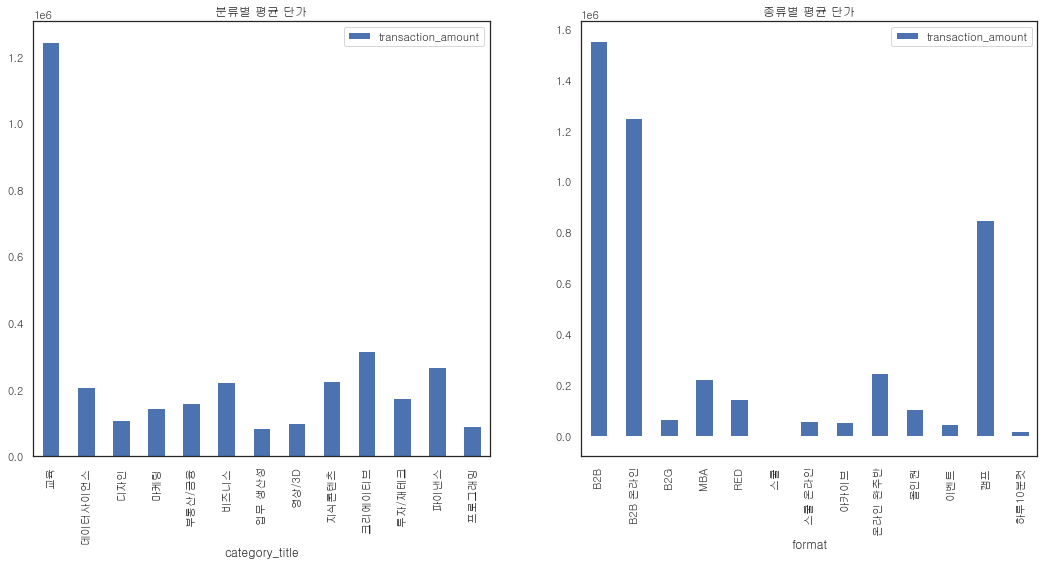

In [13]:
# 카테고리별 평균 단가 출력
f,ax = plt.subplots(1,2 ,figsize=(18,8))
df[['category_title','transaction_amount']].groupby(['category_title'],as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title("분류별 평균 단가")

df[['format','transaction_amount']].groupby(['format'],as_index=True).mean().plot.bar(ax=ax[1])
ax[1].set_title("종류별 평균 단가")
plt.show()

In [93]:
# 관리가 뭐지? -> test 코스인 것을 알 수 있었다.
df[df['course_title'].str.contains("프로모션")]
df[df['method'].isnull()]
df['method'].unique()

array(['CARD', 'VBANK', 'TRANS', 'PROMOTION', 'TRANSFER', 'ONSITE',
       'POINT', 'VOUCHER'], dtype=object)

In [27]:
# TEST용 계정 추정되는 496508 지움.
cond = df[df['customer_id']== 496508].index
df = df.drop(cond)

In [37]:
# 가장 많은 결제 내역을 가진 아이디들 내림차순 정렬

df[(df['state'] == ('COMPLETED' or'REQUESTED')) & (df['type'] ==('PAYMENT' or'REFUND'))].groupby("customer_id")['id'].count().sort_values(ascending=False).head(50)

customer_id
98685     53
50769     39
40783     34
65665     27
20784     26
6526      22
72501     21
502821    19
631       19
417924    18
14845     16
98499     16
270542    15
273223    15
390054    15
19907     15
47846     14
81583     14
573414    14
13443     14
56608     13
210621    13
83327     13
128316    13
177386    13
192232    12
30629     12
11576     12
512712    12
39807     12
171104    12
111060    12
420910    12
19892     12
480766    11
6053      11
59025     11
499543    11
67323     11
479816    11
24648     11
7055      11
69151     11
472817    11
38941     11
87007     11
83918     11
454189    11
71227     10
87311     10
Name: id, dtype: int64

In [36]:
# 테스트용 계정인지 진짜 유저인지 객관적 확인 모호함.
df[(df['customer_id']==98685.000) & (df['state']==('COMPLETED'or 'REQUESTED'))& (df['type']!='ORDER')]

,Unnamed: 0,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,...,coupon_title,coupon_discount_amount,sale_price,tax_free_amount,pg,method,subcategory_title,marketing_start_at,repurchase,2purchased
2421,2421,984635,98685,201998.000,PAYMENT,COMPLETED,올인원 패키지 : iOS 앱 개발,프로그래밍,올인원,2021-04-01 10:19:28,...,수강생 50만명 돌파 기념 감사제 쿠폰,87200.000,112000.000,112000.000,NaN,CARD,모바일앱,2020-01-14 00:00:00,True,False
3052,3052,988664,98685,204342.000,PAYMENT,COMPLETED,"올인원 패키지 : GA4 탑재, 구글 애널리틱스 끝장내기",마케팅,올인원,2021-04-03 00:08:50,...,GA4 30% 할인쿠폰,23700.000,79000.000,79000.000,NaN,CARD,데이터마케팅,2021-04-02 00:00:00,True,True
3309,3309,990338,98685,201798.000,PAYMENT,COMPLETED,올인원 패키지 : 브랜딩 2020,마케팅,올인원,2021-04-04 10:08:51,...,NaN,NaN,162100.000,162100.000,NaN,CARD,SNS마케팅,2019-11-11 00:00:00,True,True
10197,10197,1037244,98685,200399.000,PAYMENT,COMPLETED,올인원 패키지 : 리더를 위한 HR/인재경영,업무 생산성,올인원,2021-04-28 21:10:57,...,4월 1+1 페이백 이벤트 쿠폰,162100.000,111000.000,111000.000,NaN,PROMOTION,리더십,2019-03-22 00:00:00,True,True
10198,10198,1037248,98685,201849.000,PAYMENT,COMPLETED,올인원 패키지 : 그로스 마케팅,마케팅,올인원,2021-04-28 21:11:43,...,4월 1+1 페이백 이벤트 쿠폰,178000.000,123000.000,123000.000,NaN,PROMOTION,데이터마케팅,2019-11-25 00:00:00,True,True
10199,10199,1037252,98685,204286.000,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 3D 디자인 툴,디자인,올인원,2021-04-28 21:12:57,...,초격차 패키지 : 한번에 끝내는 3D 디자인툴 30% 할인 쿠폰,65700.000,219000.000,219000.000,INICIS,CARD,디자인툴,2021-04-23 00:00:00,True,True
10911,10911,1041392,98685,204775.000,PAYMENT,COMPLETED,입만 열면 인정받는 스피치 10분컷,업무 생산성,하루10분컷,2021-04-30 09:21:48,...,NaN,NaN,19500.000,19500.000,INICIS,CARD,NaN,2021-04-28 00:00:00,True,True
13256,13256,1054819,98685,204773.000,PAYMENT,COMPLETED,이것만 배우면 끝 PPT 10분컷,업무 생산성,하루10분컷,2021-05-06 09:33:53,...,NaN,NaN,19900.000,19900.000,INICIS,CARD,NaN,2021-04-28 00:00:00,True,True
15703,15703,1069671,98685,204631.000,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 node.js 웹 프로그래밍,프로그래밍,올인원,2021-05-13 23:03:57,...,[럭키룰렛] 올인원패키지,10000.000,79000.000,79000.000,INICIS,CARD,백엔드 개발,NaT,True,True
23969,23969,1127326,98685,201520.000,PAYMENT,COMPLETED,올인원 패키지 : AWS/Docker 클라우드 서버 구축,프로그래밍,올인원,2021-06-08 11:12:38,...,5월 페이백 프로모션 쿠폰,80000.000,112500.000,112500.000,INICIS,CARD,DevOps,NaT,True,True


In [44]:
# 교육의 단가가 높은이유는 대부분이 B2B 즉 기업 간 계약이라 그런 것 같다.
df[df['category_title']=='교육'][['course_title','transaction_amount']]

,course_title,transaction_amount
254,(B2B) 힐코코리아 온라인 구독 올 플랜 - 패파입주사,100000
255,(B2B) 주식회사 루나 온라인 구독 ALL PLAN - 패파입주사,750000
459,(B2B) 현대백화점 온라인 구독 올 플랜,600000
465,(B2B) 현대백화점 온라인 구독 올 플랜,600000
518,(B2B) 현대백화점 온라인 구독 올 플랜,600000
...,...,...
55952,(B2B) 건강한선택권 온라인 구독 올 플랜 - 비대면바우처,390000
55953,(B2B) 케리케이온 온라인 구독 올 플랜 - 비대면바우처,1200000
56008,(B2B) (주)공정씨컴퍼니 온라인 구독 올 플랜 - 비대면바우처,2000000
56185,(B2B) 그린오션스 온라인 구독 올 플랜 - 비대면바우처,600000


In [40]:
# 카테고리가 교육일 경우 전부 B2B 강의인 것을 알 수 있다.
df[(df['category_title']=='교육')&(df['course_title'].str.contains("B2B"))]['transaction_amount']

254       100000
255       750000
459       600000
465       600000
518       600000
          ...   
55986     390000
55987    1200000
56042    2000000
56219     600000
56300     600000
Name: transaction_amount, Length: 932, dtype: int64

In [39]:
# 카테고리가 교육일 경우엔 하위 카테고리는 없다.
df[df['category_title']=='교육']['subcategory_title'].isnull().any()

True

In [13]:
# 각각 변수를 만들어서 completed_at 을 월단위, 일단위로 나누었다.
com_month =df['completed_at'].dt.month
com_day = df['completed_at'].dt.day
com_weekday = df['completed_at'].dt.weekday
com_hour = df['completed_at'].dt.hour

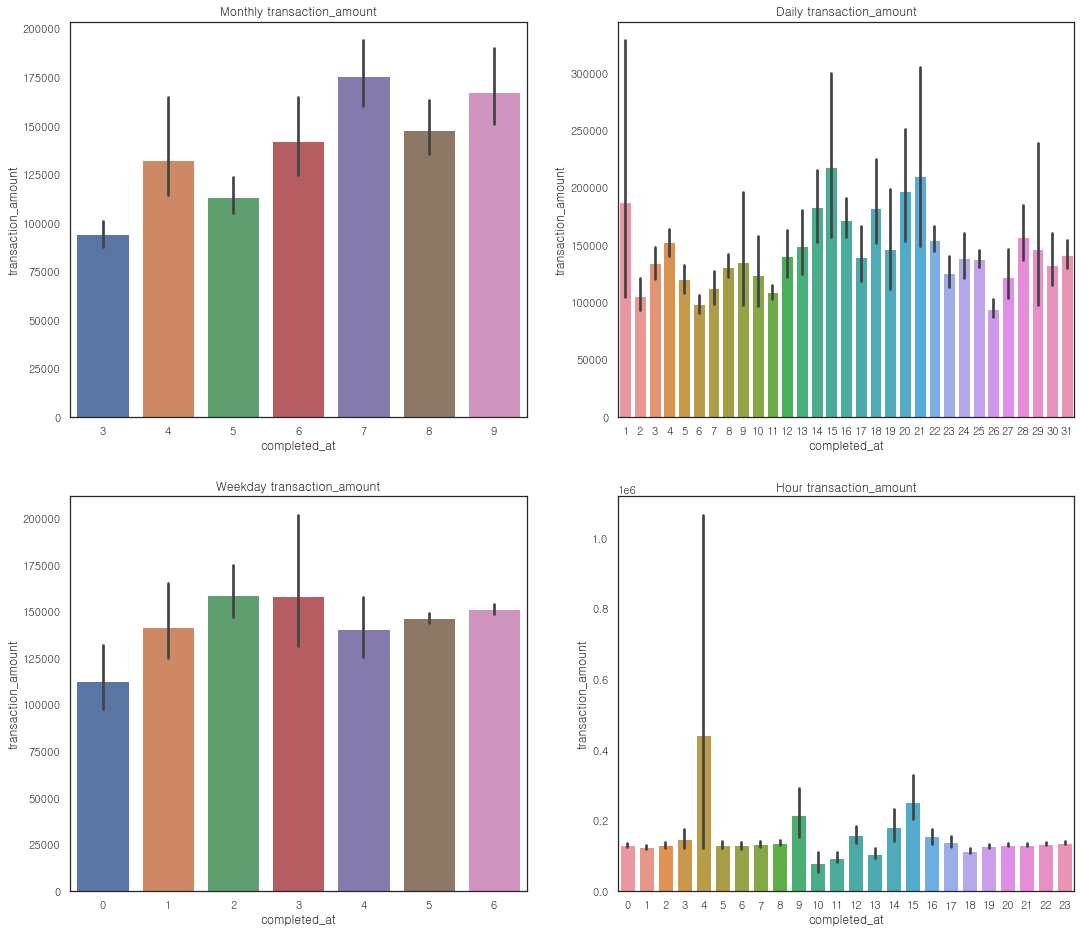

In [14]:
# 각 시간대별 평균 매출
fig, ax= plt.subplots(2,2, figsize=(18,16))

sns.barplot(data=df, x=com_month, y='transaction_amount' ,ax=ax[0,0] )
ax[0,0].set_title("Monthly transaction_amount")
sns.barplot(data=df, x=com_day, y='transaction_amount' ,ax=ax[0,1] )
ax[0,1].set_title("Daily transaction_amount")
sns.barplot(data=df, x=com_weekday, y='transaction_amount' ,ax=ax[1,0] )
ax[1,0].set_title("Weekday transaction_amount")
sns.barplot(data=df, x=com_hour, y='transaction_amount' ,ax=ax[1,1] )
ax[1,1].set_title("Hour transaction_amount")
plt.show()

## 생각나는 것

* 시간대 별로 이끌어 낼 수 있는 인사이트가 있는가?
* 쿠폰 발행이 좋은가?
* 어떻게 돈을 많이 벌지?

### 쿠폰 
* 쿠폰을 사용했을 때 결제가 활발한가?
* 쿠폰을 줘야하는, 그리고 주지 않아도 되는 카테고리는 무엇이 있을까? (쿠폰의 값이 존재하는지와 결제 건수나 점유율 간의 상관관계?)
* 

In [15]:
# 쿠폰 유무에 따른 데이터프레임 분할
df_cp = df[df['coupon_title'].notnull()]
df_ncp = df[df['coupon_title'].isnull()]

In [16]:
# 쿠폰 사용률은 42% 정도이다.
print(f"쿠폰 썼을 때의 결제량: {len(df_cp)}, 안 썼을 때: {len(df_ncp)}")
print(f"쿠폰 사용률 {len(df_cp)/len(df)*100}%")

쿠폰 썼을 때의 결제량: 23247, 안 썼을 때: 32910
쿠폰 사용률 41.39644211763449%


In [167]:
# 쿠폰 사용했을 때 카테고리별 결제건수
df_cp[df_cp['purchase']].groupby("category_title" )['id'].count().sort_values(ascending=False)


category_title
프로그래밍      7216
디자인        3122
데이터사이언스    2892
영상/3D      2813
업무 생산성     2599
마케팅        1581
부동산/금융     1185
투자/재테크      821
크리에이티브      181
비즈니스          3
Name: id, dtype: int64

In [168]:
# 쿠폰 사용하지 않은 카테고리별 결제건수
df_ncp[df_ncp['purchase']].groupby("category_title")['id'].count().sort_values(ascending=False)

category_title
프로그래밍      9474
업무 생산성     3800
데이터사이언스    3689
마케팅        2886
디자인        2278
영상/3D      2098
부동산/금융     1540
교육          925
크리에이티브      603
투자/재테크      582
지식콘텐츠        22
비즈니스         18
파이낸스         16
Name: id, dtype: int64

In [17]:
# 각각 데이터프레임의 카테고리별 결제금액의 평균을 새로운 시리즈변수에 대입
avg_ta_by_cat_cp = df_cp.groupby('category_title')['transaction_amount'].mean()
avg_ta_by_cat_ncp = df_ncp.groupby('category_title')['transaction_amount'].mean()

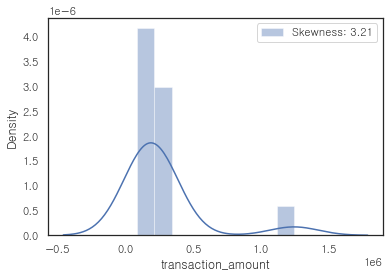

In [22]:
# skew 정도 확인 3.21로 조정이 필요하다
g = sns.distplot(avg_ta_by_cat_ncp, label='Skewness: %.2f'%(avg_ta_by_cat_ncp.skew()))
g= g.legend(loc='best')

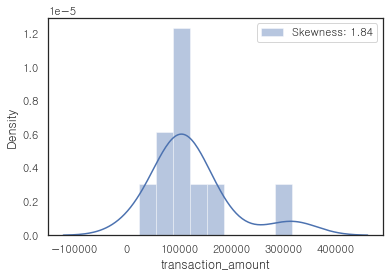

In [23]:
g = sns.distplot(avg_ta_by_cat_cp, label='Skewness: %.2f'%(avg_ta_by_cat_cp.skew()))
g= g.legend(loc='best')

In [ ]:
# 로그 취함(나중에 머신러닝 넣는다면,)

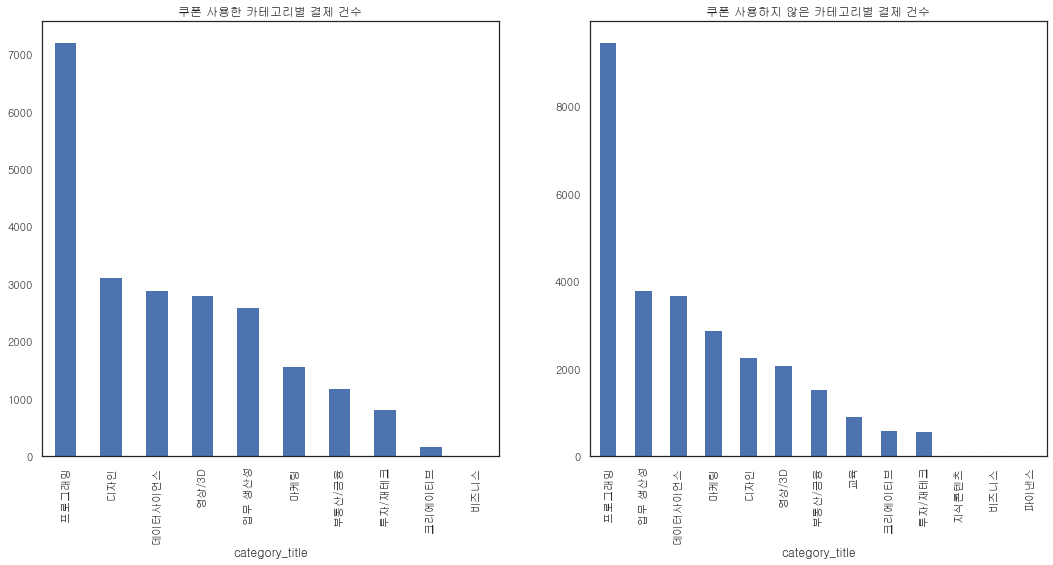

In [24]:
# 쿠폰 사용 유무에 따른 카테고리별 결제 건수
f,ax = plt.subplots(1,2 ,figsize=(18,8))
df_cp[df_cp['purchase']].groupby("category_title")['id'].count().sort_values(ascending=False).plot.bar(ax=ax[0])
ax[0].set_title("쿠폰 사용한 카테고리별 결제 건수")

df_ncp[df_ncp['purchase']].groupby("category_title")['id'].count().sort_values(ascending=False).plot.bar(ax=ax[1])
ax[1].set_title("쿠폰 사용하지 않은 카테고리별 결제 건수")
plt.show()

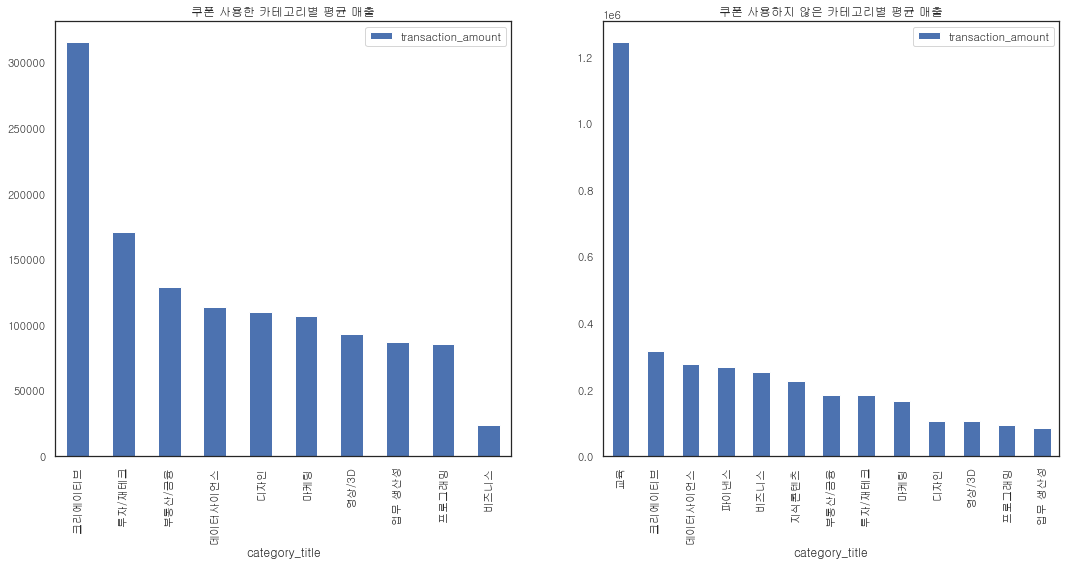

In [25]:
# 쿠폰 사용 유무에 따른 카테고리별 평균 매출
f,ax = plt.subplots(1,2 ,figsize=(18,8))
df_cp[['category_title','transaction_amount']].groupby(['category_title'],as_index=True).mean().sort_values(by='transaction_amount',ascending=False).plot.bar(ax=ax[0])
ax[0].set_title("쿠폰 사용한 카테고리별 평균 매출")

df_ncp[['category_title','transaction_amount']].groupby(['category_title'],as_index=True).mean().sort_values(by='transaction_amount',ascending=False).plot.bar(ax=ax[1])
ax[1].set_title("쿠폰 사용하지 않은 카테고리별 평균 매출")
plt.show()

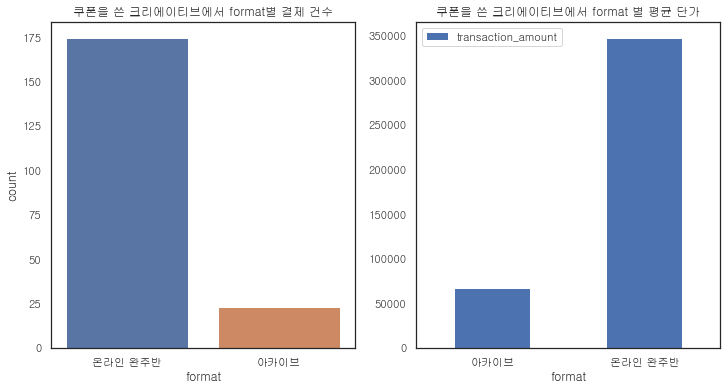

In [77]:
# 쿠폰을 쓴 크리에이티브가 건당 평균 매출이 튀는 이유는 198의 결제 금액 중에 175개가 단가가 높은 온라인 완주반이기 때문
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.countplot(df_cp[df_cp['category_title']=='크리에이티브']['format'], ax=ax[0])
ax[0].set_title("쿠폰을 쓴 크리에이티브에서 format별 결제 건수")

df_cp[df_cp['category_title']=='크리에이티브'][['format','transaction_amount']].groupby("format", as_index=True).mean().plot.bar(ax= ax[1])
ax[1].set_title("쿠폰을 쓴 크리에이티브에서 format 별 평균 단가")
plt.setp(ax[1].get_xticklabels(), rotation=0)
plt.show()

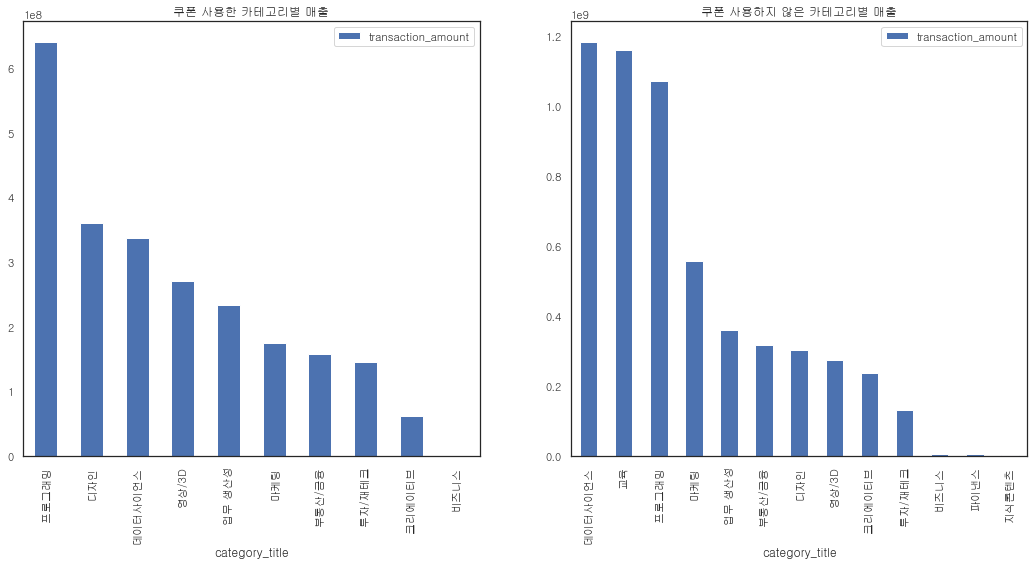

In [51]:
# 쿠폰 사용 유무에 따른 카테고리별 매출
f,ax = plt.subplots(1,2 ,figsize=(18,8))
df_cp[['category_title','transaction_amount']].groupby(['category_title'],as_index=True).sum().sort_values(by='transaction_amount',ascending=False).plot.bar(ax=ax[0])
ax[0].set_title("쿠폰 사용한 카테고리별 매출")

df_ncp[['category_title','transaction_amount']].groupby(['category_title'],as_index=True).sum().sort_values(by='transaction_amount',ascending=False).plot.bar(ax=ax[1])
ax[1].set_title("쿠폰 사용하지 않은 카테고리별 매출")
plt.show()

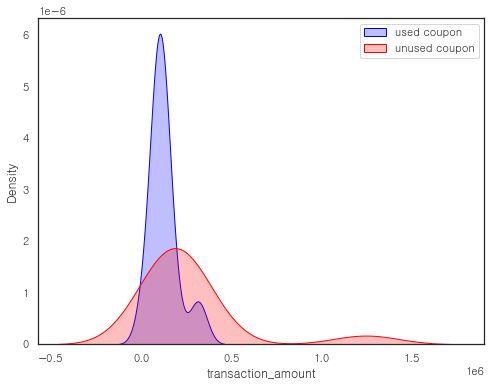

In [115]:
# 쿠폰 사용 유무에 따른 평균 매출의 빈도
plt.figure(figsize=(8,6))

sns.kdeplot(x=avg_ta_by_cat_cp, color="Blue", shade = True, label="used coupon" )
sns.kdeplot(x=avg_ta_by_cat_ncp,color ='Red', shade = True, label="unused coupon")

plt.legend()
plt.show()

#### 쿠폰 줘야하는, 안 줘도 되는

* 쿠폰의 영향력 지수 만들어보자
* 쿠폰을 사용한 결제건수/ 전체 결제건수 -> 사용률
* 각 카테고리별 매출 점유율 비교?


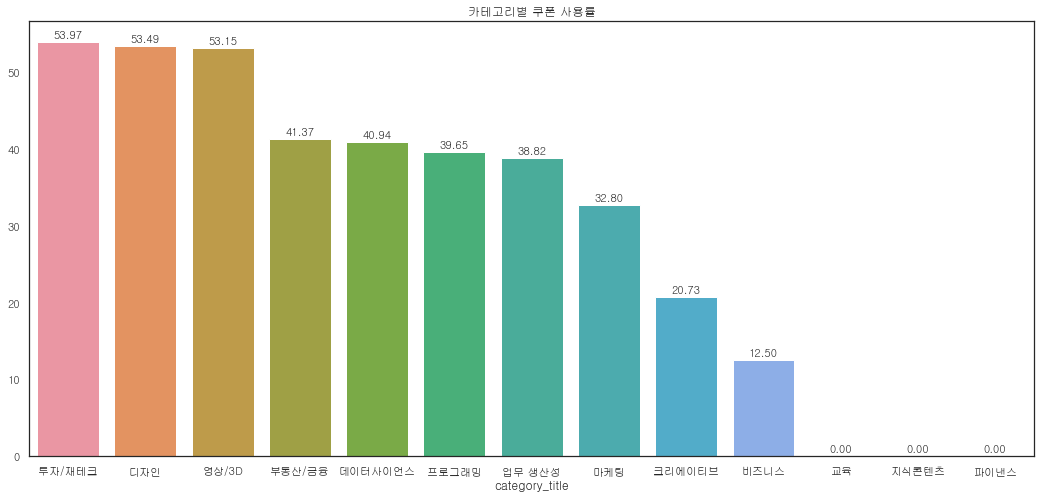

In [18]:
# 카테고리별 쿠폰 사용률
cp_use = (df.groupby("category_title").count()['coupon_title']/df.groupby("category_title").count()['id'] *100).sort_values(ascending=False)

plt.figure(figsize=(18,8))
ax = sns.barplot(x=cp_use.index,y=cp_use.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)
    
ax.set_title("카테고리별 쿠폰 사용률",)
plt.show()

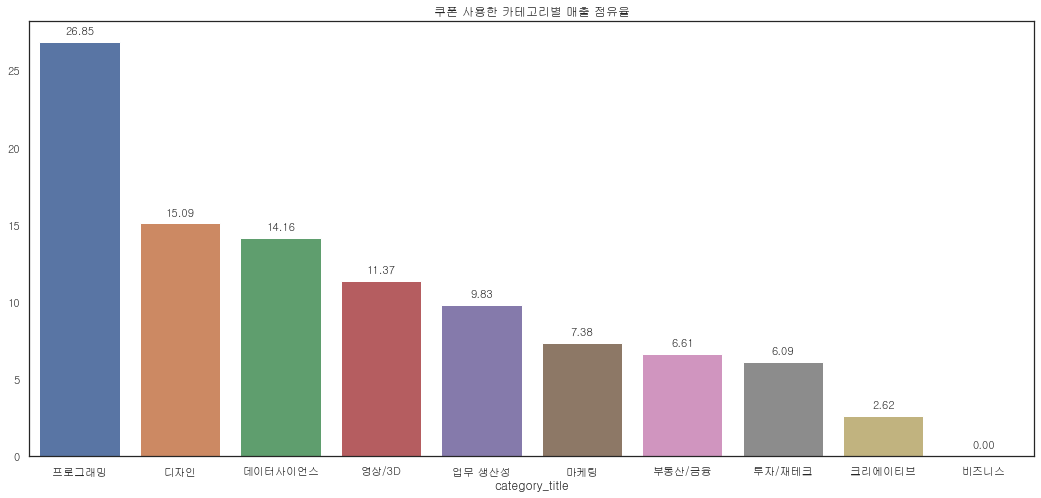

In [19]:
# 쿠폰 사용한 카테고리별 매출 점유율
cp_ocp =(df_cp.groupby("category_title").sum()['transaction_amount'] /sum(df_cp['transaction_amount'])*100).sort_values(ascending=False)
plt.figure(figsize=(18,8))
ax =sns.barplot(x=cp_ocp.index,y=cp_ocp.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)
ax.set_title("쿠폰 사용한 카테고리별 매출 점유율")
plt.show()

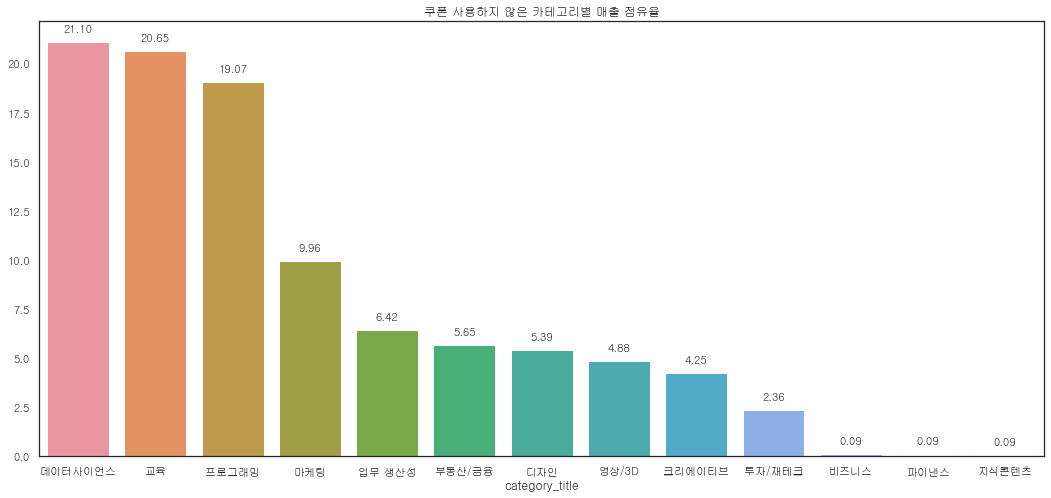

In [20]:
# 쿠폰 사용하지 않은 카테고리별 매출 점유율
ncp_ocp = (df_ncp.groupby("category_title").sum()['transaction_amount'] /sum(df_ncp['transaction_amount'])*100).sort_values(ascending=False)

plt.figure(figsize=(18,8))
ax = sns.barplot(x=ncp_ocp.index,y=ncp_ocp.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

ax.set_title("쿠폰 사용하지 않은 카테고리별 매출 점유율")
plt.show()

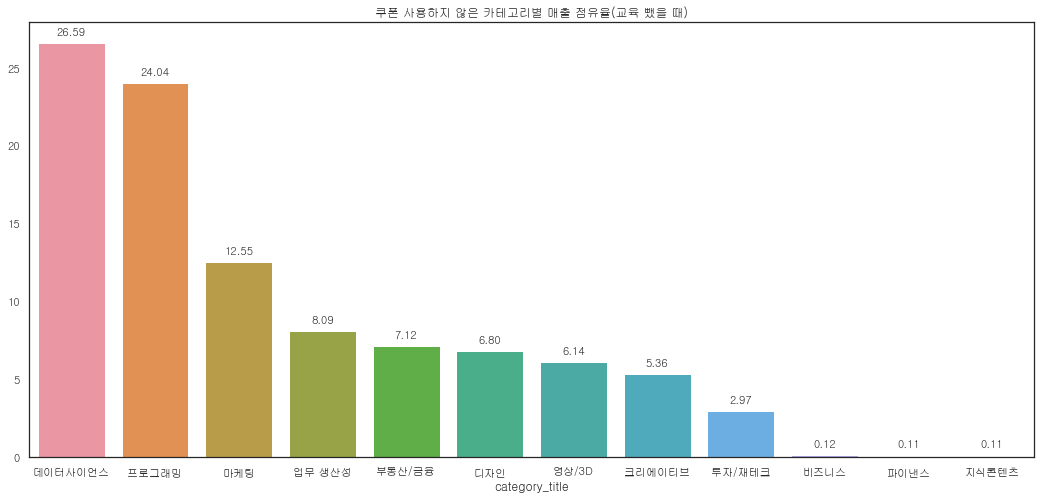

In [21]:
# 쿠폰 사용하지 않은 카테고리별 매출 점유율 ( 교육 뺐을 때)
df_ncp_ = df_ncp[df_ncp['category_title'] != '교육']
ncp_ocp = (df_ncp_.groupby("category_title").sum()['transaction_amount'] /sum(df_ncp_['transaction_amount'])*100).sort_values(ascending=False)

plt.figure(figsize=(18,8))
ax = sns.barplot(x=ncp_ocp.index,y=ncp_ocp.values)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

ax.set_title("쿠폰 사용하지 않은 카테고리별 매출 점유율(교육 뺐을 때)")
plt.show()

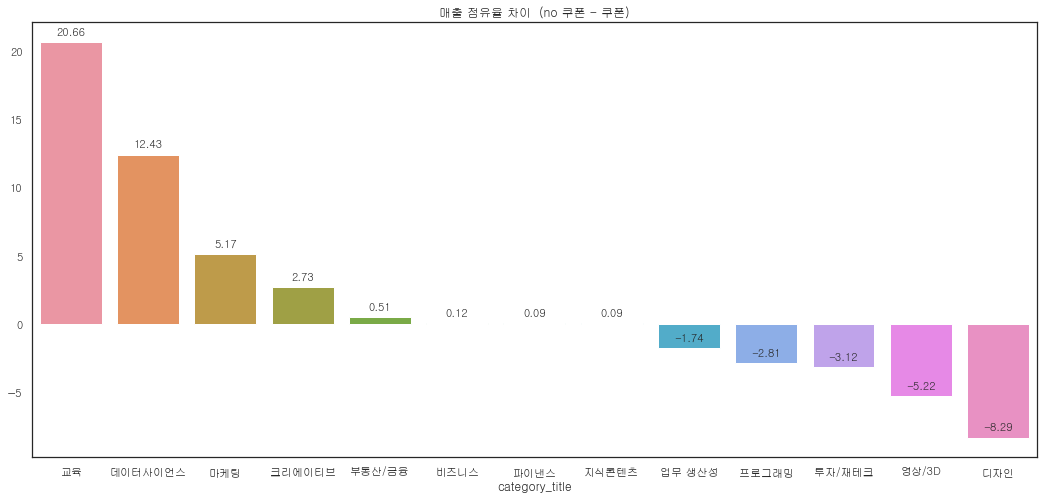

In [22]:
# 매출 점유율 차이  (no 쿠폰 - 쿠폰) -> 양수이면 쿠폰안 쓴게 매출 점유율이 더 높음, 음수면 쿠폰 쓴 게 매출 점유율이 더 높음.
diff_ocp = ncp_ocp - cp_ocp
diff_ocp['교육'] =20.657
diff_ocp['지식콘텐츠']=0.088
diff_ocp['파이낸스'] = 0.091
diff_ocp = diff_ocp.sort_values(ascending=False)
plt.figure(figsize=(18,8))
ax = sns.barplot(x=diff_ocp.index,y=diff_ocp.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

    
ax.set_title("매출 점유율 차이  (no 쿠폰 - 쿠폰)")
plt.show()

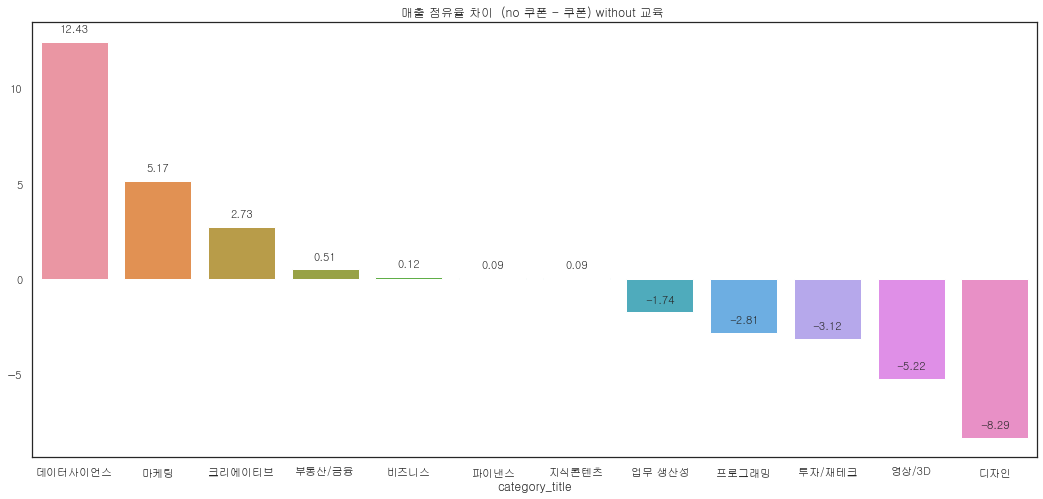

In [23]:
# 매출 점유율 차이 (교육 뺐을 때) (no 쿠폰 - 쿠폰) -> 양수이면 쿠폰안 쓴게 매출 점유율이 더 높음, 음수면 쿠폰 쓴 게 매출 점유율이 더 높음.
diff_ocp = ncp_ocp - cp_ocp
diff_ocp['지식콘텐츠']=0.088
diff_ocp['파이낸스'] = 0.091
diff_ocp = diff_ocp.sort_values(ascending=False)
plt.figure(figsize=(18,8))
ax = sns.barplot(x=diff_ocp.index,y=diff_ocp.values)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

    
ax.set_title("매출 점유율 차이  (no 쿠폰 - 쿠폰) without 교육 ")
plt.show()

#### 소결론

* 교육은 논외 (B2B 계약)

* 데이터사이언스, 마케팅, 크리에이티브, 부동산/금융 카테고리는 쿠폰을 쓰지 않았을 때 매출 점유율이 더 높은 것으로 보아, 쿠폰 발행을 줄이는 시도를 해볼 필요가 있다.

* 업무 생산성, 투자/재테크, 영상/3D, 프로그래밍, 디자인 분야는 쿠폰을 사용했을 때 매출 점유율이 더 높았기 때문에 쿠폰을 더 발행할 필요가 있다.

### 쿠폰의 사용 시간대 조사

* df_cp를 이용하여 쿠폰의 사용시간대를 조사해본다.

In [24]:
# 각각 변수를 만들어서 completed_at 을 월단위, 일단위로 나누었다.
com_month_cp =df_cp['completed_at'].dt.month
com_day_cp = df_cp['completed_at'].dt.day
com_weekday_cp = df_cp['completed_at'].dt.weekday
com_hour_cp = df_cp['completed_at'].dt.hour

In [25]:
df_cp['com_month_cp'] =df_cp['completed_at'].dt.month
df_cp['com_day_cp'] = df_cp['completed_at'].dt.day
df_cp['com_weekday_cp'] = df_cp['completed_at'].dt.weekday
df_cp['com_hour_cp'] = df_cp['completed_at'].dt.hour

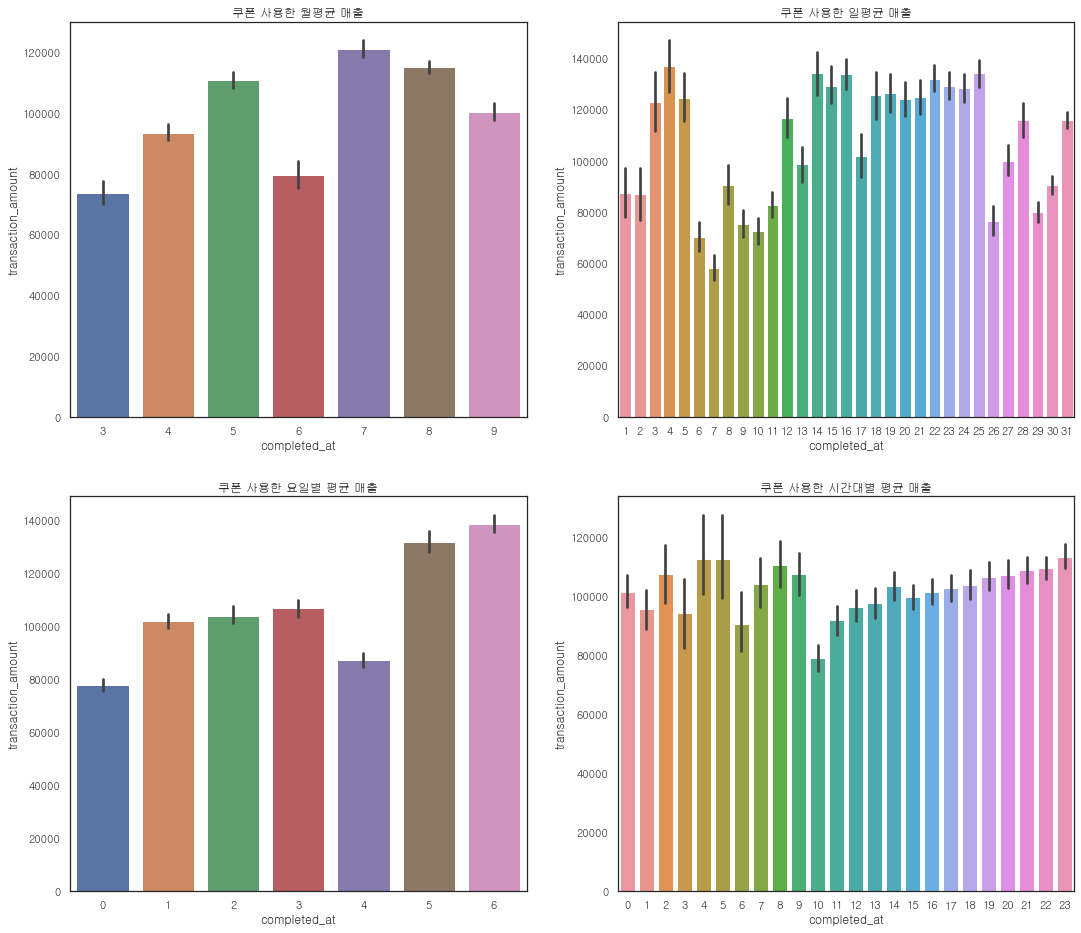

In [26]:
# 쿠폰 사용했을 때 각 시간대별 평균 매출
fig, ax= plt.subplots(2,2, figsize=(18,16))

sns.barplot(data=df_cp, x=com_month_cp, y='transaction_amount' ,ax=ax[0,0] )
ax[0,0].set_title("쿠폰 사용한 월평균 매출")
sns.barplot(data=df_cp, x=com_day_cp, y='transaction_amount' ,ax=ax[0,1] )
ax[0,1].set_title("쿠폰 사용한 일평균 매출")
sns.barplot(data=df_cp, x=com_weekday_cp, y='transaction_amount' ,ax=ax[1,0] )
ax[1,0].set_title("쿠폰 사용한 요일별 평균 매출")
sns.barplot(data=df_cp, x=com_hour_cp, y='transaction_amount' ,ax=ax[1,1] )
ax[1,1].set_title("쿠폰 사용한 시간대별 평균 매출")
plt.show()


* 주말에 평균매출이 많고, 늦은 시간대일수록 평균매출이 많다.

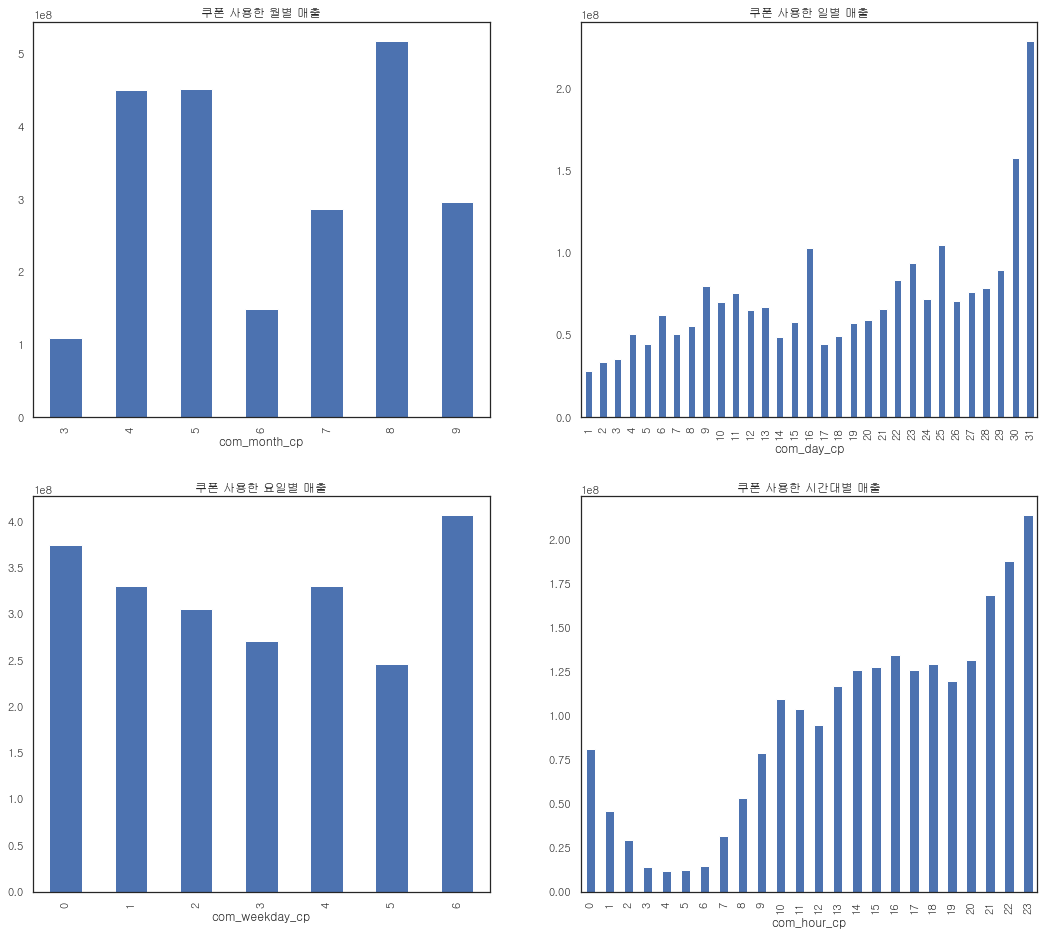

In [27]:
# 쿠폰을 사용했을 때 각 시간대별 결제 매출
f,ax = plt.subplots(2,2 ,figsize=(18,16))
df_cp[df_cp['purchase']].groupby("com_month_cp")['transaction_amount'].sum().plot.bar(ax=ax[0,0])
ax[0,0].set_title("쿠폰 사용한 월별 매출")


df_cp[df_cp['purchase']].groupby("com_day_cp")['transaction_amount'].sum().plot.bar(ax=ax[0,1])
ax[0,1].set_title("쿠폰 사용한 일별 매출")

df_cp[df_cp['purchase']].groupby("com_weekday_cp")['transaction_amount'].sum().plot.bar(ax=ax[1,0])
ax[1,0].set_title("쿠폰 사용한 요일별 매출")

df_cp[df_cp['purchase']].groupby("com_hour_cp")['transaction_amount'].sum().plot.bar(ax=ax[1,1])
ax[1,1].set_title("쿠폰 사용한 시간대별 매출")
plt.show()

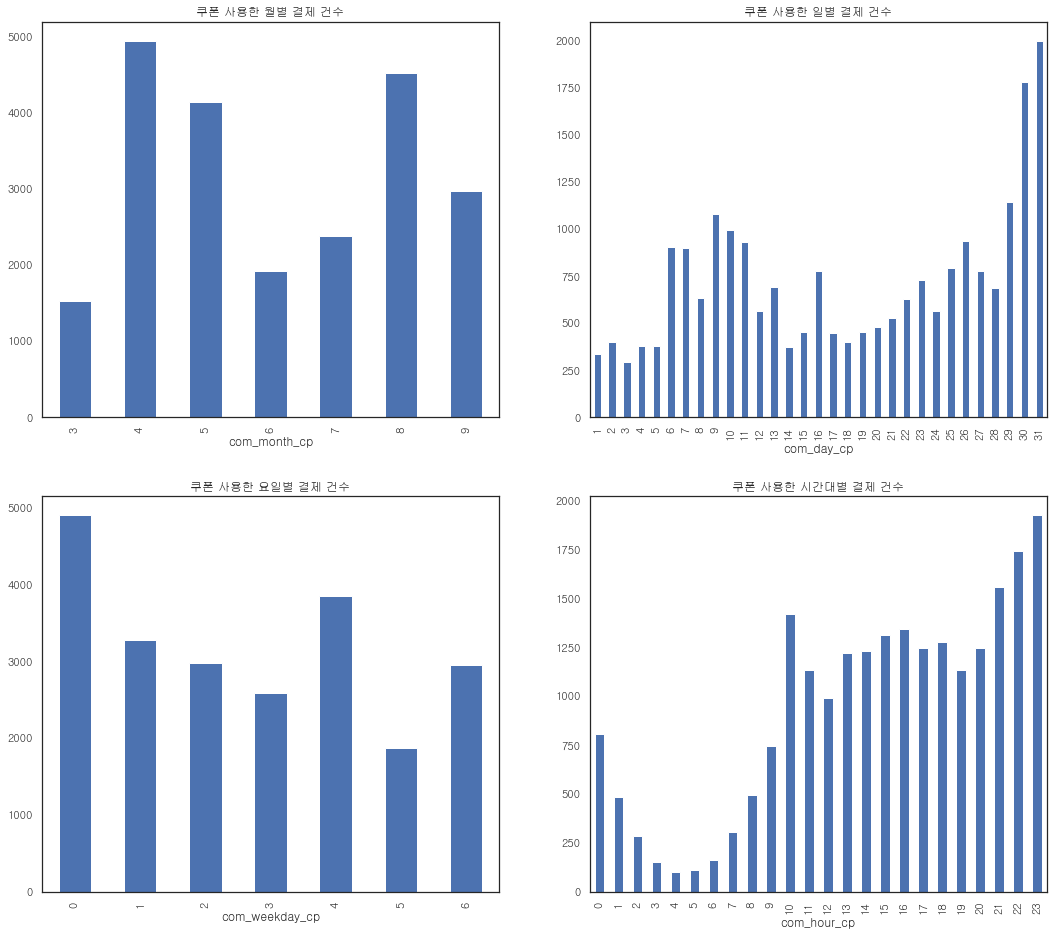

In [28]:
# 쿠폰을 사용했을 때 각 시간대별 순수 결제 건수
f,ax = plt.subplots(2,2 ,figsize=(18,16))
df_cp[df_cp['purchase']].groupby("com_month_cp")['id'].count().plot.bar(ax=ax[0,0])
ax[0,0].set_title("쿠폰 사용한 월별 결제 건수")


df_cp[df_cp['purchase']].groupby("com_day_cp")['id'].count().plot.bar(ax=ax[0,1])
ax[0,1].set_title("쿠폰 사용한 일별 결제 건수")

df_cp[df_cp['purchase']].groupby("com_weekday_cp")['id'].count().plot.bar(ax=ax[1,0])
ax[1,0].set_title("쿠폰 사용한 요일별 결제 건수")

df_cp[df_cp['purchase']].groupby("com_hour_cp")['id'].count().plot.bar(ax=ax[1,1])
ax[1,1].set_title("쿠폰 사용한 시간대별 결제 건수")
plt.show()

#### 소결론

* 주말엔 평균매출이 제일 좋은데 정작 순수 결제건수는 그에 비례하지 않는다. 오히려 결제건수는 월요일이 가장 많았다.
* 월말(30, 31일)에 결제 건수가 제일 많다. 쿠폰의 사용기간때문이 아닐까 추측해본다.
* 시간대는 평균매출과 동일하게 시간이 늦어질수록 많아졌다.

* 전체 매출과 순수결제 건수로 보면 그래프가 비슷하다.

In [29]:
# 일요일 대해서 탐구 일요일은 결제건수는 적은데 평균매출, 총매출은 둘다 1위다.
df_cp_weekend= df_cp[(df_cp['com_weekday_cp']==6)]
df_cp_weekend.head()

,id,customer_id,course_id,type,state,course_title,category_title,format,completed_at,transaction_amount,...,pg,method,subcategory_title,marketing_start_at,purchase,refund,com_month_cp,com_day_cp,com_weekday_cp,com_hour_cp
0,970657,72297,204246,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,...,NaN,CARD,NaN,2021-03-04,True,False,3,28,6,15
1,970658,478028,201797,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,...,NaN,CARD,PPT/보고서,2019-11-14,True,False,3,28,6,15
2,970669,478033,203178,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,...,NaN,CARD,영상 편집,2020-12-02,True,False,3,28,6,15
4,970676,478035,203720,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,...,NaN,CARD,프론트엔드 개발,2021-02-02,False,False,3,28,6,15
7,970704,471759,204068,PAYMENT,COMPLETED,올인원 패키지 : 마디아의 UX/UI 포트폴리오,디자인,올인원,2021-03-28 15:46:22,89000,...,NaN,CARD,UX/UI,2021-03-11,True,False,3,28,6,15


### 날짜

* 판매시작일로부터 결제일을 다 빼면 개시가 된 때로부터 각각의 결제일이 나온다. 이걸로 뭘할까?
* 날짜의 결측치는 어떻게 처리할까? (같은 카테고리 + 같은 서브카테고리)

In [32]:
df_mkt= df[df['marketing_start_at'].notnull()]

In [33]:
# 날짜 결측율
print("날짜 결측률: ",(1-len(df_mkt)/len(df))*100 ,"%")

날짜 결측률:  17.803657602792168 %


In [34]:
# 같은 카테고리 + 같은 서브카테고리 판매일의 평균값으로 채움
df['marketing_start_at'] = df['marketing_start_at'].fillna(df.groupby(["category_title","subcategory_title"])['marketing_start_at'].transform('mean'))

In [35]:
print(f"결측치 해소: {df['marketing_start_at'].notnull().sum()-len(df_mkt)} 개")

결측치 해소: 5036 개


In [36]:
# 결측치 채운 원래 df도 period추가
# 각 결제일자에서 각 코스 판매시작일을 빼서 새로운 컬럼으로 추가
df['period'] = df['completed_at'] - df['marketing_start_at']
df['period'] = df[df['purchase']]['period'].dt.days

posx and posy should be finite values
posx and posy should be finite values


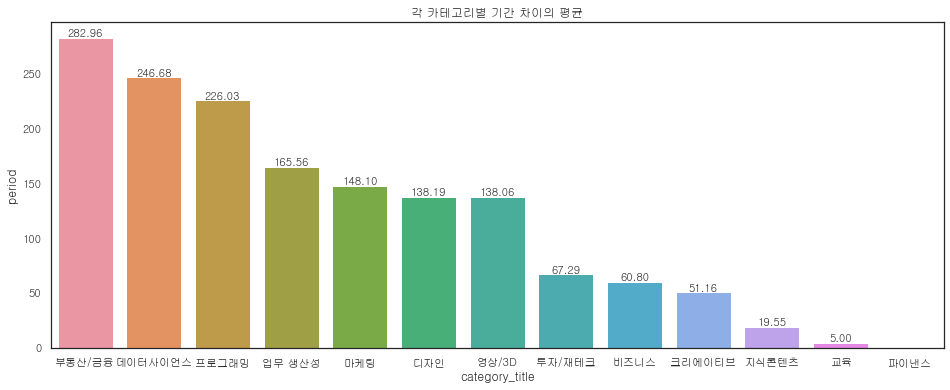

In [37]:
# 각 카테고리별 기간 차이의 평균 (df)
plt.figure(figsize=(16,6))

daysgone = df.groupby("category_title")['period'].mean().to_frame().sort_values(by='period', ascending=False)
g= sns.barplot(data=daysgone, x= daysgone.index, y ='period')
g.set_title("각 카테고리별 기간 차이의 평균")
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)


plt.show()

- 부동산/금융, 데이터사이언스, 프로그래밍 분야는 기간차이의 평균이 크다. 즉,
- 1. 생긴지 오래된 강의를 사람들이 결제를 하고 있거나, 
- 2. 새로운 강의가 추가가 되지 않거나,
- 3. 새로운 강의가 추가되도 사람들이 수강을 하지 않는다는 뜻.

- 매출과 비교해보자.

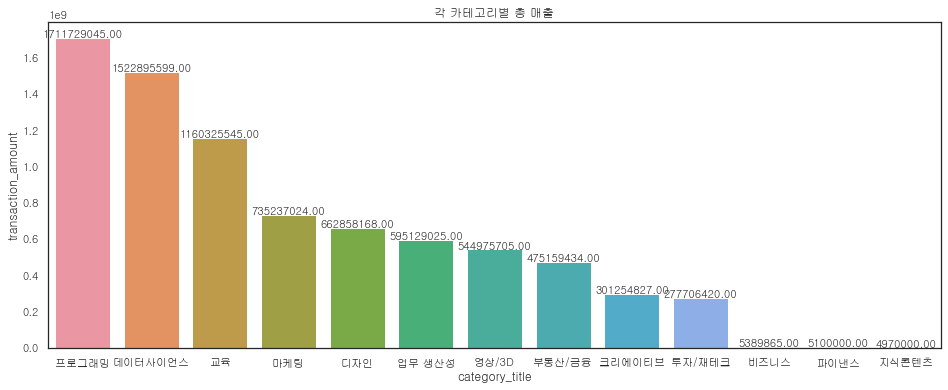

In [38]:
# 각 카테고리별 매출과 비교하여 조정해야할 카테고리 선정
#1. 카테고리별 매출

plt.figure(figsize=(16,6))

cat_sum_amnt = df.groupby("category_title")['transaction_amount'].sum().to_frame().sort_values(by='transaction_amount', ascending=False)
g= sns.barplot(data=cat_sum_amnt, x= cat_sum_amnt.index, y ='transaction_amount')
g.set_title("각 카테고리별 총 매출")
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

plt.show()

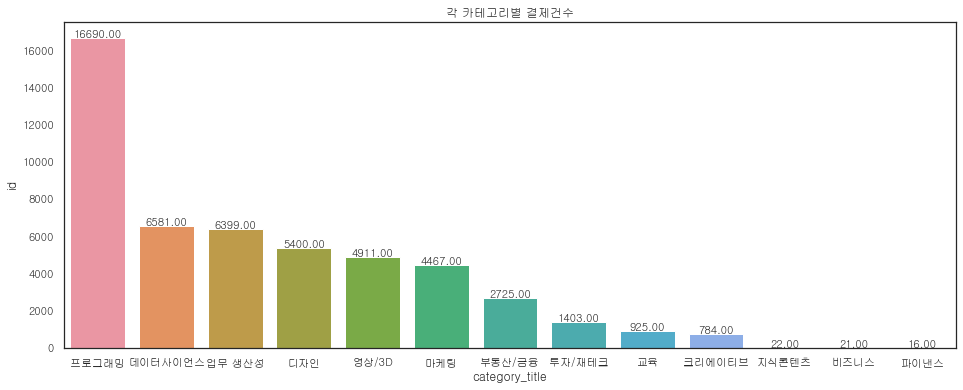

In [39]:
# 각 카테고리별 매출과 비교하여 조정해야할 카테고리 선정
#2. 카테고리별 순수 결제 건수

plt.figure(figsize=(16,6))

cat_sum_pay = df[df['purchase']].groupby("category_title")['id'].count().to_frame().sort_values(by='id', ascending=False)
g= sns.barplot(data=cat_sum_pay, x= cat_sum_pay.index, y ='id')
g.set_title("각 카테고리별 결제건수")
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width() / 2., height +0.5, '%.2f' %height, ha = 'center', size = 11)

plt.show()

In [41]:
# 각 카테고리별 평균 단가
df.groupby("category_title")['transaction_amount'].mean().to_frame().sort_values(by='transaction_amount', ascending=False)

,transaction_amount
category_title,
교육,1244984.490
크리에이티브,315450.081
파이낸스,268421.053
지식콘텐츠,225909.091
비즈니스,224577.708
데이터사이언스,209447.889
투자/재테크,176545.722
부동산/금융,160744.058
마케팅,146578.354


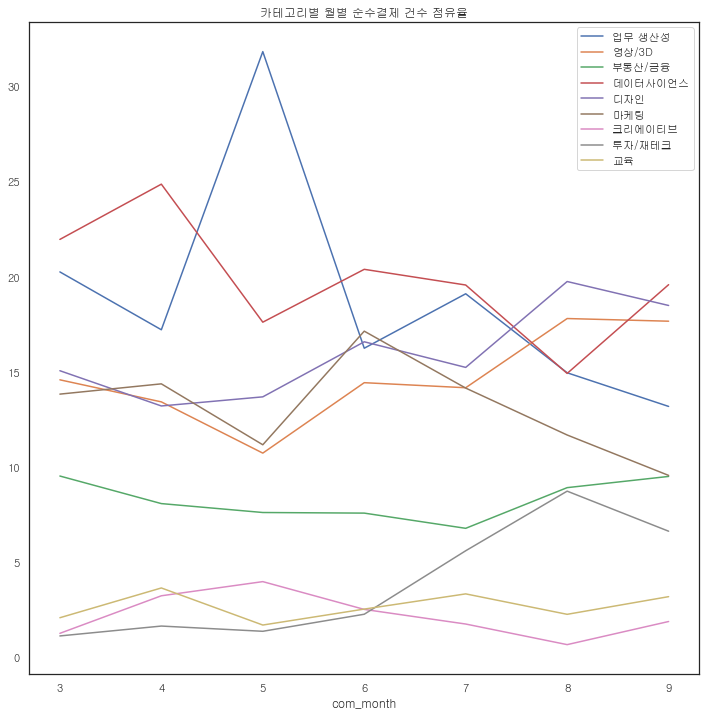

In [128]:
# 각 카테고리별 월별 순수결제 건수 점유율 꺾은선 그래프를 그려보자
df['com_month'] = df['completed_at'].dt.month
plt.figure(figsize=(12,12))

df_mdf = df[(df['category_title'] != '프로그래밍')&(df['category_title'] != '비즈니스')&(df['category_title'] != '지식콘텐츠')&(df['category_title'] != '파이낸스')]



for i in list_:
    df_ = df[(df['purchase'])&(df['category_title']==i)].groupby("com_month")['id'].count()
    g= sns.lineplot(x=df_.index, y=(df_.values/df_mdf[df_mdf['purchase']].groupby("com_month")['id'].count().values)*100)

plt.legend(labels= list_)
plt.title("카테고리별 월별 순수결제 건수 점유율")
plt.show()

#### 소결론
- 압도적 1등 프로그래밍과 최근에 신설되어 옛날 자료가 없는 파이낸스, 지식콘텐츠, 비즈니스 부분은 뺐다.

- 부동산/금융, 업무생산성 분야는 기간이 긴 것에 비해 매출이 뛰어나지 않는다.
- 마케팅은 6월부터 결제건수의 점유율이 하락세이고 구매까지의 평균기간이 148일이다. 
- 업무생산성 분야는 5월이후로 점유율이 우하향을 띄고 있다.

- 따라서 이 분야들은 새로운 강의를 충원할 필요가 있다.

In [203]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))